In [97]:
import gdrive_refs as names
import utils
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [98]:
root = "./../data/"
datasets = dict()
for name in names.gdrive_dic:
    address = root+name[1]
    datasets[name[1]] = pd.read_csv(address, on_bad_lines='skip')

# Predicting deaths

We saw in the `relating_aqi_pm25` notebook that there is not correlation between $AQI$ and $PM2.5$ with the dataset provided by EPA. We concluded that the correlation itself is not linear and also depends on other factors such that $PM10$ and pollutant concentration in the air. This way, we want to create a predictor of deaths attributed to air pollution with the sole values of:
- $AQI$
- $PM2.5/10$
- Concentrations of $CO_2$, $SO_2$
To do this, we will center our analysis on the data provided by the World Health Organization and the EPA to build a predictor that can accurately predict the yearly death tolls on the US alone.

# Building the table

Let us join the tables comprising the counties $AQIs$, $PM2.5$, $PM10$ and finally the levels in pollutants.

In [99]:
pm25 = datasets['pm25National.csv']
# We only take the years 2000 to 2016
pm25_filtered = pm25[(pm25['Year']>=2000) & (pm25['Year']<=2016)].loc[:,['Year','Mean']].rename(columns = {'Mean':'PM2.5 Mean'})
pm25_filtered

,Year,PM2.5 Mean
0,2000,13.497383
1,2001,13.225067
2,2002,12.827120
3,2003,12.332006
4,2004,12.023175
5,2005,12.868947
6,2006,11.622669
7,2007,11.920433
8,2008,10.891642
9,2009,9.883770


In [100]:
years = [str(i) for i in range(2001,2017)]
annual_aqi_us_county = datasets["annual_aqi_by_county_2000.csv"].loc[:,['Year', 'State', 'County','Median AQI']]
increment = 1
for year in years:
    df = datasets["annual_aqi_by_county_"+year+".csv"].loc[:,['Year', 'State', 'County','Median AQI']]
    annual_aqi_us_county = pd.concat([annual_aqi_us_county, df], axis=0)
    increment += 1
annual_aqi_us_county = annual_aqi_us_county.reset_index().drop(columns='index')
annual_aqi_us_filtered = annual_aqi_us_county.groupby('Year').mean().reset_index()
annual_aqi_us_filtered

,Year,Median AQI
0,2000,39.700441
1,2001,39.335074
2,2002,38.721453
3,2003,38.533104
4,2004,37.500871
5,2005,39.577797
6,2006,38.954464
7,2007,40.444946
8,2008,38.860000
9,2009,36.533212


In [101]:
years = [str(i) for i in range(2000,2017)]
epa_pollutants_codes = ["44201","42401","42101","42602"]
url = ["https://aqs.epa.gov/aqsweb/airdata/daily_"+epa_pollutants_codes[i]+"_"+years[j]+".zip" for i in range(len(epa_pollutants_codes)) for j in range(len(years))]
url

['https://aqs.epa.gov/aqsweb/airdata/daily_44201_2000.zip',
 'https://aqs.epa.gov/aqsweb/airdata/daily_44201_2001.zip',
 'https://aqs.epa.gov/aqsweb/airdata/daily_44201_2002.zip',
 'https://aqs.epa.gov/aqsweb/airdata/daily_44201_2003.zip',
 'https://aqs.epa.gov/aqsweb/airdata/daily_44201_2004.zip',
 'https://aqs.epa.gov/aqsweb/airdata/daily_44201_2005.zip',
 'https://aqs.epa.gov/aqsweb/airdata/daily_44201_2006.zip',
 'https://aqs.epa.gov/aqsweb/airdata/daily_44201_2007.zip',
 'https://aqs.epa.gov/aqsweb/airdata/daily_44201_2008.zip',
 'https://aqs.epa.gov/aqsweb/airdata/daily_44201_2009.zip',
 'https://aqs.epa.gov/aqsweb/airdata/daily_44201_2010.zip',
 'https://aqs.epa.gov/aqsweb/airdata/daily_44201_2011.zip',
 'https://aqs.epa.gov/aqsweb/airdata/daily_44201_2012.zip',
 'https://aqs.epa.gov/aqsweb/airdata/daily_44201_2013.zip',
 'https://aqs.epa.gov/aqsweb/airdata/daily_44201_2014.zip',
 'https://aqs.epa.gov/aqsweb/airdata/daily_44201_2015.zip',
 'https://aqs.epa.gov/aqsweb/airdata/dai

In [102]:
import zipfile

for data_url in url:
    data_dir="./../data"
    if '44201' in data_url:
        zip_file = 'ozone_'+data_url[-8:-3]+'zip'
        csv_file = 'ozone_'+data_url[-8:-3]+'csv'
        utils.fetch_and_cache(data_url, zip_file, data_dir, force=False)
        with zipfile.ZipFile(data_dir+'/'+zip_file, 'r') as zip_ref:
            zip_ref.extractall(data_dir)
            os.remove(data_dir+'/'+zip_file)
            os.rename(data_dir+'/'+data_url[-20:-3]+'csv', data_dir+'/'+csv_file)
    if '42401' in data_url:
        zip_file = 'so2_'+data_url[-8:-3]+'zip'
        csv_file = 'so2_'+data_url[-8:-3]+'csv'
        utils.fetch_and_cache(data_url, zip_file, data_dir, force=False)
        with zipfile.ZipFile(data_dir+'/'+zip_file, 'r') as zip_ref:
            zip_ref.extractall(data_dir)
            os.remove(data_dir+'/'+zip_file)
            os.rename(data_dir+'/'+data_url[-20:-3]+'csv', data_dir+'/'+csv_file)
    if '42101' in data_url:
        zip_file = 'co_'+data_url[-8:-3]+'zip'
        csv_file = 'co_'+data_url[-8:-3]+'csv'
        utils.fetch_and_cache(data_url, zip_file, data_dir, force=False)
        with zipfile.ZipFile(data_dir+'/'+zip_file, 'r') as zip_ref:
            zip_ref.extractall(data_dir)
            os.remove(data_dir+'/'+zip_file)
            os.rename(data_dir+'/'+data_url[-20:-3]+'csv', data_dir+'/'+csv_file)
    if '42602' in data_url:
        zip_file = 'no2_'+data_url[-8:-3]+'zip'
        csv_file = 'no2_'+data_url[-8:-3]+'csv'
        utils.fetch_and_cache(data_url, zip_file, data_dir, force=False)
        with zipfile.ZipFile(data_dir+'/'+zip_file, 'r') as zip_ref:
            zip_ref.extractall(data_dir)
            os.remove(data_dir+'/'+zip_file)
            os.rename(data_dir+'/'+data_url[-20:-3]+'csv', data_dir+'/'+csv_file)

Downloading... Done!
Downloading... Done!
Downloading... Done!
Downloading... Done!
Downloading... Done!
Downloading... Done!
Downloading... Done!
Downloading... Done!
Downloading... Done!
Downloading... Done!
Downloading... Done!
Downloading... Done!
Downloading... Done!
Downloading... Done!
Downloading... Done!
Downloading... Done!
Downloading... Done!
Downloading... Done!
Downloading... Done!
Downloading... Done!
Downloading... Done!
Downloading... Done!
Downloading... Done!
Downloading... Done!
Downloading... Done!
Downloading... Done!
Downloading... Done!
Downloading... Done!
Downloading... Done!
Downloading... Done!
Downloading... Done!
Downloading... Done!
Downloading... Done!
Downloading... Done!
Downloading... Done!
Downloading... Done!
Downloading... Done!
Downloading... Done!
Downloading... Done!
Downloading... Done!
Downloading... Done!
Downloading... Done!
Downloading... Done!
Downloading... Done!
Downloading... Done!
Downloading... Done!
Downloading... Done!
Downloading..

In [103]:
co_concetration = pd.read_csv('./../data/co_2000.csv') 
co_concetration = co_concetration.loc[pd.notna(co_concetration['AQI']),['AQI']].mean().reset_index().rename(columns={0: "CO AQI"}).drop(columns='index')
co_concetration['Year'] = pd.Series(2000)

years = [str(i) for i in range(2001,2017)]
for year in years:
    df = pd.read_csv('./../data/co_'+year+'.csv')
    df = df.loc[pd.notna(df['AQI']),['AQI']].mean().reset_index().rename(columns={0: "CO AQI"}).drop(columns='index')
    df['Year'] = pd.Series(int(year))
    co_concetration = pd.concat([co_concetration, df], axis=0)
co_concetration


/Users/aymeric/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (27) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,CO AQI,Year
0,12.536678,2000
0,11.818071,2001
0,10.889842,2002
0,10.349962,2003
0,9.350434,2004
0,8.662587,2005
0,8.126856,2006
0,7.137915,2007
0,6.471224,2008
0,6.055578,2009


In [104]:
no2_concetration = pd.read_csv('./../data/no2_2000.csv') 
no2_concetration = no2_concetration.loc[pd.notna(no2_concetration['AQI']),['AQI']].mean().reset_index().rename(columns={0: "NO2 AQI"}).drop(columns='index')
no2_concetration['Year'] = pd.Series(2000)

years = [str(i) for i in range(2001,2017)]
for year in years:
    df = pd.read_csv('./../data/co_'+year+'.csv')
    df = df.loc[pd.notna(df['AQI']),['AQI']].mean().reset_index().rename(columns={0: "NO2 AQI"}).drop(columns='index')
    df['Year'] = pd.Series(int(year))
    no2_concetration = pd.concat([no2_concetration, df], axis=0)
no2_concetration

/Users/aymeric/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (27) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,NO2 AQI,Year
0,27.491528,2000
0,11.818071,2001
0,10.889842,2002
0,10.349962,2003
0,9.350434,2004
0,8.662587,2005
0,8.126856,2006
0,7.137915,2007
0,6.471224,2008
0,6.055578,2009


In [105]:
ozone_concetration = pd.read_csv('./../data/ozone_2000.csv') 
ozone_concetration = ozone_concetration.loc[pd.notna(ozone_concetration['AQI']),['AQI']].mean().reset_index().rename(columns={0: "Ozone AQI"}).drop(columns='index')
ozone_concetration['Year'] = pd.Series(2000)

years = [str(i) for i in range(2001,2017)]
for year in years:
    df = pd.read_csv('./../data/co_'+year+'.csv')
    df = df.loc[pd.notna(df['AQI']),['AQI']].mean().reset_index().rename(columns={0: "Ozone AQI"}).drop(columns='index')
    df['Year'] = pd.Series(int(year))
    ozone_concetration = pd.concat([ozone_concetration, df], axis=0)
ozone_concetration

/Users/aymeric/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (0,27) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/aymeric/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (27) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Ozone AQI,Year
0,45.949634,2000
0,11.818071,2001
0,10.889842,2002
0,10.349962,2003
0,9.350434,2004
0,8.662587,2005
0,8.126856,2006
0,7.137915,2007
0,6.471224,2008
0,6.055578,2009


In [106]:
so2_concetration = pd.read_csv('./../data/so2_2000.csv') 
so2_concetration = so2_concetration.loc[pd.notna(so2_concetration['AQI']),['AQI']].mean().reset_index().rename(columns={0: "SO2 AQI"}).drop(columns='index')
so2_concetration['Year'] = pd.Series(2000)

years = [str(i) for i in range(2001,2017)]
for year in years:
    df = pd.read_csv('./../data/co_'+year+'.csv')
    df = df.loc[pd.notna(df['AQI']),['AQI']].mean().reset_index().rename(columns={0: "SO2 AQI"}).drop(columns='index')
    df['Year'] = pd.Series(int(year))
    so2_concetration = pd.concat([so2_concetration, df], axis=0)
so2_concetration

/Users/aymeric/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (27) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,SO2 AQI,Year
0,20.215974,2000
0,11.818071,2001
0,10.889842,2002
0,10.349962,2003
0,9.350434,2004
0,8.662587,2005
0,8.126856,2006
0,7.137915,2007
0,6.471224,2008
0,6.055578,2009


In [107]:
deaths = pd.read_csv('./../data/total_death_world.csv').rename(columns={'Deaths - Cause: All causes - Risk: Air pollution - Sex: Both - Age: All Ages (Number)':'Deaths'})
deaths_filtered = deaths.loc[(deaths['Code']=='USA') & (deaths['Year']>=2000) & (deaths['Year']<=2016),['Year','Deaths']].reset_index().drop(columns='index')
deaths_filtered

,Year,Deaths
0,2000,102989
1,2001,101326
2,2002,99744
3,2003,96526
4,2004,92316
5,2005,90806
6,2006,88050
7,2007,83248
8,2008,78860
9,2009,74243


# Joining all tables


In [108]:
joined_all = pm25_filtered
dfs_to_join = [annual_aqi_us_filtered,co_concetration,no2_concetration,ozone_concetration,so2_concetration,deaths_filtered]

for df in dfs_to_join:
    joined_all = joined_all.merge(right=df,left_on='Year',right_on='Year')

<AxesSubplot:>

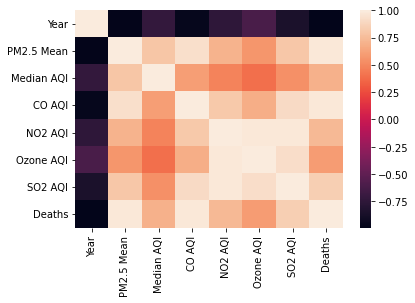

In [109]:
sns.heatmap(joined_all.corr())

In [125]:
joined_all

,Year,PM2.5 Mean,Median AQI,CO AQI,NO2 AQI,Ozone AQI,SO2 AQI,Deaths
0,2000,13.497383,39.700441,12.536678,27.491528,45.949634,20.215974,102989
1,2001,13.225067,39.335074,11.818071,11.818071,11.818071,11.818071,101326
2,2002,12.827120,38.721453,10.889842,10.889842,10.889842,10.889842,99744
3,2003,12.332006,38.533104,10.349962,10.349962,10.349962,10.349962,96526
4,2004,12.023175,37.500871,9.350434,9.350434,9.350434,9.350434,92316
5,2005,12.868947,39.577797,8.662587,8.662587,8.662587,8.662587,90806
6,2006,11.622669,38.954464,8.126856,8.126856,8.126856,8.126856,88050
7,2007,11.920433,40.444946,7.137915,7.137915,7.137915,7.137915,83248
8,2008,10.891642,38.860000,6.471224,6.471224,6.471224,6.471224,78860
9,2009,9.883770,36.533212,6.055578,6.055578,6.055578,6.055578,74243


<AxesSubplot:xlabel='PM2.5 Mean', ylabel='Deaths'>

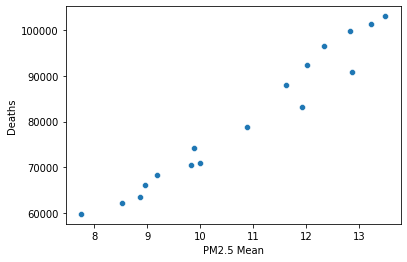

In [128]:
sns.scatterplot(data = joined_all, x = 'PM2.5 Mean', y='Deaths')

[4062.84644239 -301.2763005   826.21079849  826.21079849  826.21079849
  826.21079849] 0.9971463229660013 0.8683390617142906


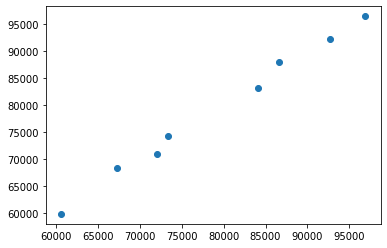

In [129]:
from sklearn import linear_model as lm
import scipy as sc
from sklearn.model_selection import train_test_split

model = lm.LinearRegression()
X = joined_all.iloc[:,1:7]
y = joined_all.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

model.fit(X_train,y_train)
y_pred = model.predict(X_train)
y_valid = model.predict(X_test)
print(model.coef_,sc.stats.pearsonr(y_pred, y_train)[0],
sc.stats.pearsonr(y_valid, y_test)[0])

plt.scatter(y_pred,y_train)